# Analysing Onsala-1 radio spectra obtained from OSO 20m telescope

In this notebook, we will analyse a spectrum of Onsala-1 molecular cloud obtained from 20m telescope at OSO. The spectra were measured in radio frequencies and have four emission lines of $CH_3CCH$. The main goal is to find the area under the lines, which is basically the integrated antenna temperature under these lines. With this we can compute the column density of the $CH_3CCH$.

The focus of this notebook is Onsala-1. Once we have worked it out, we can make a routine to compute the same for the rest of the targets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from glob import glob
import astropy.constants as con
import utils as utl
from scipy.optimize import minimize
import dynesty
from scipy import stats
import pickle
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal

We first make a list of all fits file which has spectrum of Onsala-1. We also list the system temperature and the total integration time, which we need to compute the combined/average spectrum (to gain a higher S/N).

In [2]:
# Listing all of the fits file
f1 = glob(os.getcwd() + '/Data/*.fits')
ons, tsys, int_time = np.array([]), np.array([]), np.array([])
print('File\t\tObject\t\tT_sys\tINTTIME')
print('-----------------------------------------------')
for i in range(len(f1)):
    hdul = fits.open(f1[i])
    hdr = hdul[0].header
    if hdr['OBJECT'] == 'Onsala 1':
        ons = np.hstack((ons, f1[i]))
        tsys, int_time = np.hstack((tsys, hdr['TSYS'])),\
             np.hstack((int_time, hdr['INTTIME']))
        print(f1[i].split('/')[-1] + '\t' + hdr['OBJECT'] + '\t'\
             + str(hdr['TSYS']) + '\t' + str(hdr['INTTIME']))

File		Object		T_sys	INTTIME
-----------------------------------------------
2136049a.fits	Onsala 1	222.9	202.402
2136054a.fits	Onsala 1	210.84	203.066
2136035a.fits	Onsala 1	234.93	203.169
2136032a.fits	Onsala 1	234.93	202.38
2136068a.fits	Onsala 1	210.54	203.964
2136071a.fits	Onsala 1	210.54	202.298
2136057a.fits	Onsala 1	210.84	203.958
2136038a.fits	Onsala 1	234.93	202.369
2136021a.fits	Onsala 1	262.31	202.416
2136060a.fits	Onsala 1	210.84	202.228
2136046a.fits	Onsala 1	222.9	204.005
2136027a.fits	Onsala 1	262.31	202.399
2136065a.fits	Onsala 1	210.54	203.191
2136043a.fits	Onsala 1	222.9	203.941
2136024a.fits	Onsala 1	262.31	202.373


We can now compute an average spectrum out of all of these spectra!

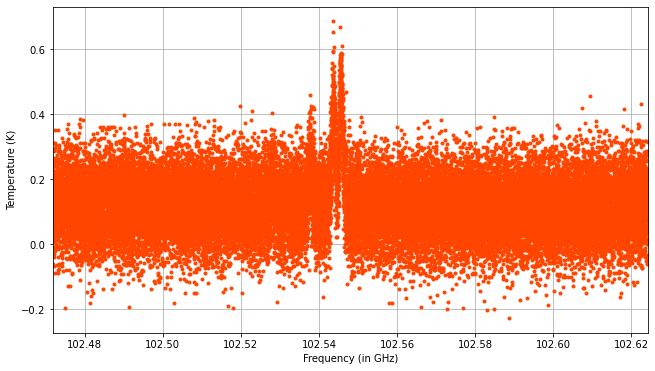

In [3]:
# For zeroth spectra
hdul5 = fits.open(ons[0])
hdr5, dta5 = hdul5[0].header, hdul5[0].data[0][0]
ii5 = np.arange(hdr5['NAXIS1']) + 1
freq_all = hdr5['RESTFREQ'] + hdr5['CRVAL1'] + hdr5['CDELT1']*(ii5-hdr5['CRPIX1'])
freq_all = int_time[0]*freq_all/tsys[0]
temp_all = int_time[0]*dta5/tsys[0]
# For all other spectra
for i in range(len(ons)-1):
    hdul5 = fits.open(ons[i+1])
    hdr5, dta5 = hdul5[0].header, hdul5[0].data[0][0]
    ii5 = np.arange(hdr5['NAXIS1']) + 1
    frq5 = hdr5['RESTFREQ'] + hdr5['CRVAL1'] + hdr5['CDELT1']*(ii5-hdr5['CRPIX1'])
    # Saving the data
    temp_all = np.vstack((temp_all, int_time[i+1]*dta5/tsys[i+1]))
    freq_all = np.vstack((freq_all, int_time[i+1]*frq5/tsys[i+1]))
# Weighted average (weighted with int_time/Tsys) over all the spectra
freq_avg = np.sum(freq_all, axis=0)/np.sum(int_time/tsys)
temp_avg = np.sum(temp_all, axis=0)/np.sum(int_time/tsys)

# Plotting the result:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(freq_avg/1e9, temp_avg, fmt='.', c='orangered')
plt.xlabel('Frequency (in GHz)')
plt.ylabel('Temperature (K)')
plt.xlim([np.min(freq_avg/1e9), np.max(freq_avg/1e9)])
plt.grid()

There we go! This is a nice spectrum of Onsala 1!
We can first convert frequency to the velocity first -- to do this we can use the following Doppler formula:

$$v = c \cdot \frac{f_s - f_o}{f_s}$$

The symbols have their usual meanings.

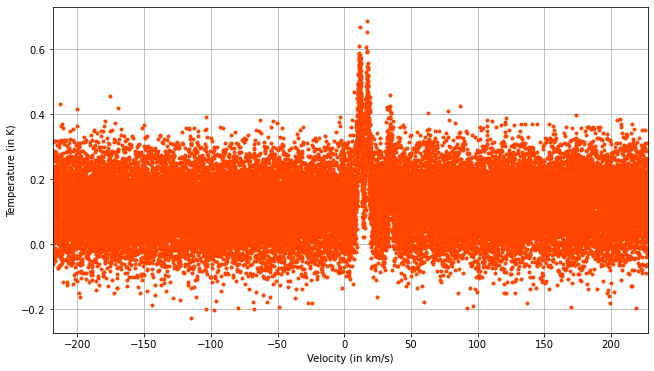

In [4]:
# To find the rest frame frequency
diff = freq_avg - hdr5['OBSFREQ']
rest_freq = hdr5['RESTFREQ']#freq_avg + diff
# To find the velocity of the target!
velo_avg = con.c.value*(rest_freq - freq_avg)/rest_freq
velo_avg = velo_avg + hdr5['VLSR']# + hdr5['VELO-GEO'] + hdr5['VELO-HEL']
# We can plot the results
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo_avg/1e3, temp_avg, fmt='.', c='orangered')
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([np.min(velo_avg/1e3), np.max(velo_avg/1e3)])
plt.grid()

## How to compute the uncertainties on these points

One peculier thing about this spectrum is that its points do not have errors on them. We all know that errors are fundamentals to any spectrum --- but, how do we estimate the unceratainties? One way out could be to evaluate the standard deviation of the _whole_ spectrum and treat it as a stadard deviation of a Gaussian distribution with zero mean, which then makes an array of uncertainties.

We can do this bacause the spctral lines are like outliers to the continumm (see, the histogram of the spectrum below), which is basically a noise.

Below we implement this:

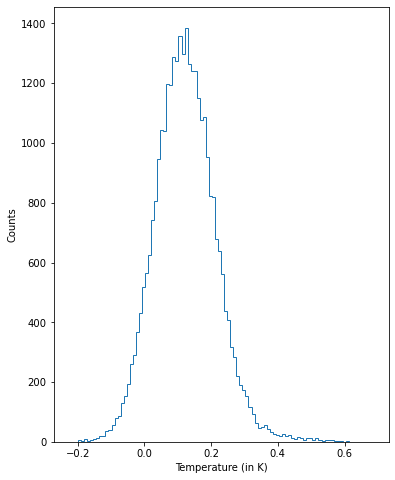

In [5]:
plt.figure(figsize=(6, 8))
plt.hist(temp_avg, bins=100, histtype='step')
plt.xlabel('Temperature (in K)')
plt.ylabel('Counts')
temp_err = np.abs(np.random.normal(0, np.std(temp_avg), len(temp_avg)))

And this is how the final spectrum would look like...

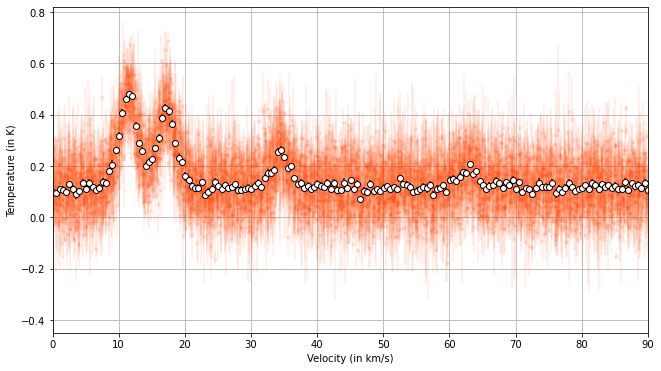

In [6]:
# We can plot the results
## Binned data
velo_bin, temp_bin, temp_err_bin, _ = utl.lcbin(velo_avg, temp_avg, binwidth=500)
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo_avg/1e3, temp_avg, yerr=temp_err, fmt='.', c='orangered', alpha=0.1)
plt.errorbar(velo_bin/1e3, temp_bin, yerr=temp_err_bin, fmt='o', mfc='white', c='black')
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([0, 90])
plt.grid()

## And the fitting...

So, there are four lines (though we cannot see them individually) along with some offset trend. What we can do is to build a model that has four gaussian models and a linear model. Then we can use `dynesty` to fit the model.

In [7]:
def model(x, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4):
    ln1 = utl.line(x, m, c)
    gau1 = utl.gaus(x, am1, mu1, si1)
    gau2 = utl.gaus(x, am2, mu2, si2)
    gau3 = utl.gaus(x, am3, mu3, si3)
    gau4 = utl.gaus(x, am4, mu4, si4)
    return ln1 + gau1 + gau2 + gau3 + gau4

def chi_sqrd(x):
    #global velo_avg, temp_avg, temp_err
    m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4 = x
    mod = model(velo_avg, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4)
    chi2 = (temp_avg - mod)**2
    return 0.5*np.sum(chi2)/2

def log_like(x):
    #global velo_avg, temp_avg, temp_err
    m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4 = x
    mods = model(velo_avg, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4)
    resid = temp_avg-mods
    chi2 = np.sum(-resid**2/(2*temp_err*temp_err))
    errs = np.sum(-np.log(temp_err))
    return chi2+errs

def neg_loglike(x):
    #global velo_avg, temp_avg, temp_err
    m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4 = x
    mods = model(velo_avg, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4)
    resid = temp_avg-mods
    chi2 = np.sum(-resid**2/(2*temp_err*temp_err))
    errs = np.sum(-np.log(temp_err))
    return -chi2-errs

We can now use `scipy.optimize.minimize` to find the "first" best-fitted parameters.

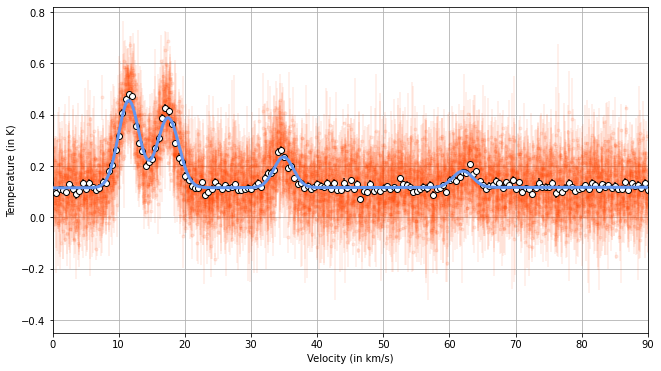

In [8]:
xinit = np.array([0., 0.1, 0.4, 0.3, 0.13, 0.1,\
     11000, 18000, 35000, 62000, 1.5*1000, 1.5*1000, 1.5*1000, 1.5*1000])
soln = minimize(chi_sqrd, x0=xinit, method='BFGS')

vall = np.linspace(np.min(velo_avg), np.max(velo_avg), 10000)
best_fit = model(vall, *soln.x)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo_avg/1e3, temp_avg, yerr=temp_err, fmt='.', c='orangered', alpha=0.1)
plt.errorbar(velo_bin/1e3, temp_bin, yerr=temp_err_bin, fmt='o', mfc='white', c='black')
plt.plot(vall/1e3, best_fit, c='cornflowerblue', lw=3, zorder=5)
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([0, 90])
plt.grid()

In [9]:
# Printing the results:
print(soln.x)

[2.69358634e-08 1.15218185e-01 3.39066737e-01 2.72469651e-01
 1.19294956e-01 6.37455180e-02 1.15161422e+04 1.74616235e+04
 3.49341989e+04 6.20295858e+04 1.56422412e+03 1.63584755e+03
 1.49027685e+03 1.50582179e+03]


Using `dynesty` to perform a more robust analysis!

In [10]:
def uniform(t, a, b):
    return (b-a)*t + a
def stand(a, loc, scale):
    return (a-loc)/scale

def prior_transform(ux):
    x = np.array(ux)
    # Linear function:
    x[0], x[1] = uniform(ux[0], -0.01, 0.01), stats.loguniform.ppf(ux[1], a=1e-2, b=5e-1)
    # Amplitudes:
    x[2], x[3], x[4], x[5] = stats.loguniform.ppf(ux[2], a=1e-2, b=1.), stats.loguniform.ppf(ux[3], a=1e-2, b=1.),\
         stats.loguniform.ppf(ux[4], a=1e-2, b=1.), stats.loguniform.ppf(ux[5], a=1e-2, b=1.)
    # Central positions:
    x[6], x[7], x[8], x[9] = stats.norm.ppf(ux[6], loc=soln.x[6], scale=5e3), stats.norm.ppf(ux[7], loc=soln.x[7], scale=5e3),\
         stats.norm.ppf(ux[8], loc=soln.x[8], scale=5e3), stats.norm.ppf(ux[9], loc=soln.x[9], scale=5e3)
    # Widths:
    x[10], x[11], x[12], x[13] = stats.loguniform.ppf(ux[10], a=1e3, b=1e4), stats.loguniform.ppf(ux[11], a=1e3, b=1e4),\
         stats.loguniform.ppf(ux[12], a=1e3, b=1e4), stats.loguniform.ppf(ux[13], a=1e3, b=1e4)
    return x

def prior_tight(x):
    y = []
    for i in range(len(soln.x)):
        y.append(stats.norm.ppf(x[i], loc=soln.x[i], scale=soln.x[i]/10))
    return y

In [11]:
dsampler = dynesty.DynamicNestedSampler(loglikelihood=log_like, prior_transform=prior_transform,\
    ndim=14, nlive=500, bound='multi', sample='rwalk')
dsampler.run_nested()
dres = dsampler.results

76558it [1:05:36, 19.45it/s, batch: 4 | bound: 46 | nc: 34 | ncall: 2544387 | eff(%):  3.009 | loglstar: -241860112.579 <   -inf < -241860105.521 | logz:   -inf +/-  0.528 | stop:  0.725] 


In [12]:
print('Keys: ', dres.keys())
dres.summary()

Keys:  ['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'batch_nlive', 'batch_bounds', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale']
Summary
niter: 76558
ncall: 2544387
eff(%):  3.009
logz: -241860233.493 +/-  1.180


/Users/japa6985/opt/anaconda3/envs/dynesty12/lib/python3.9/site-packages/dynesty/utils.py:458: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


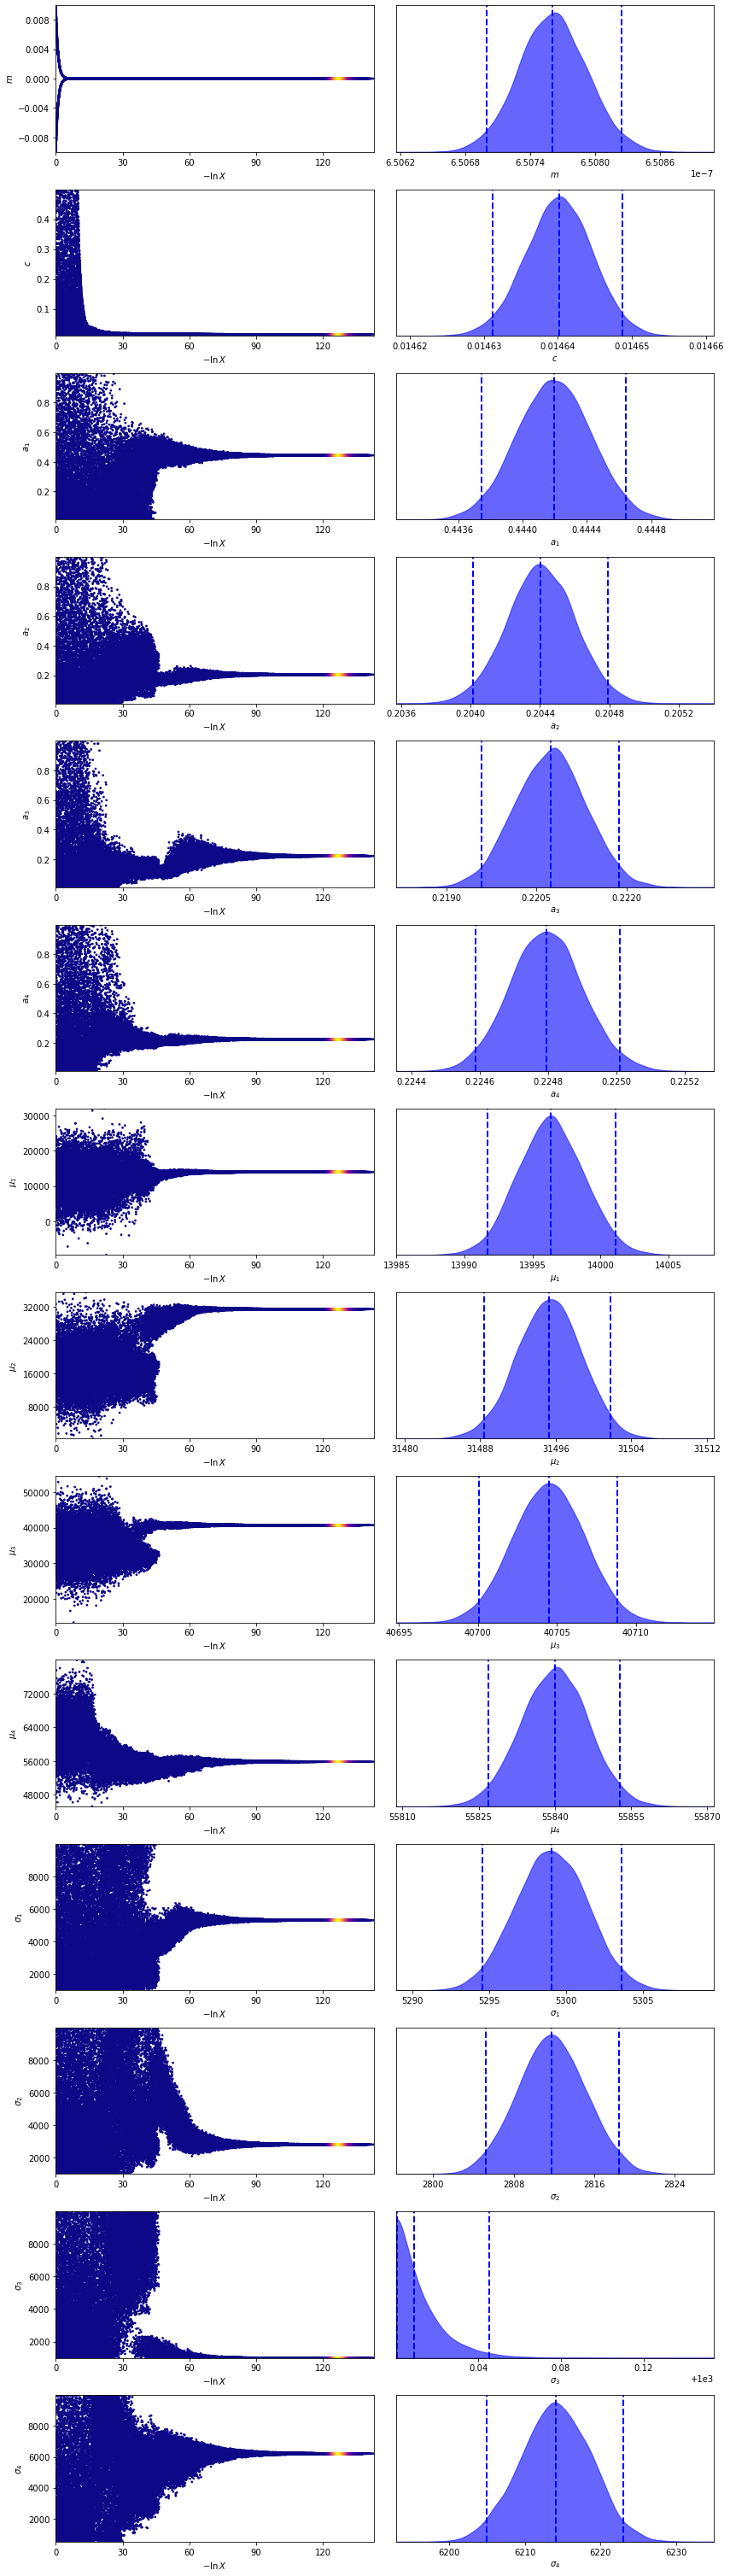

In [13]:
labels = [r'$m$', r'$c$', r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$',\
    r'$\mu_1$', r'$\mu_2$', r'$\mu_3$', r'$\mu_4$',\
    r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$', r'$\sigma_4$']

fig, axes = dyplot.traceplot(dres, labels=labels)
fig.tight_layout()


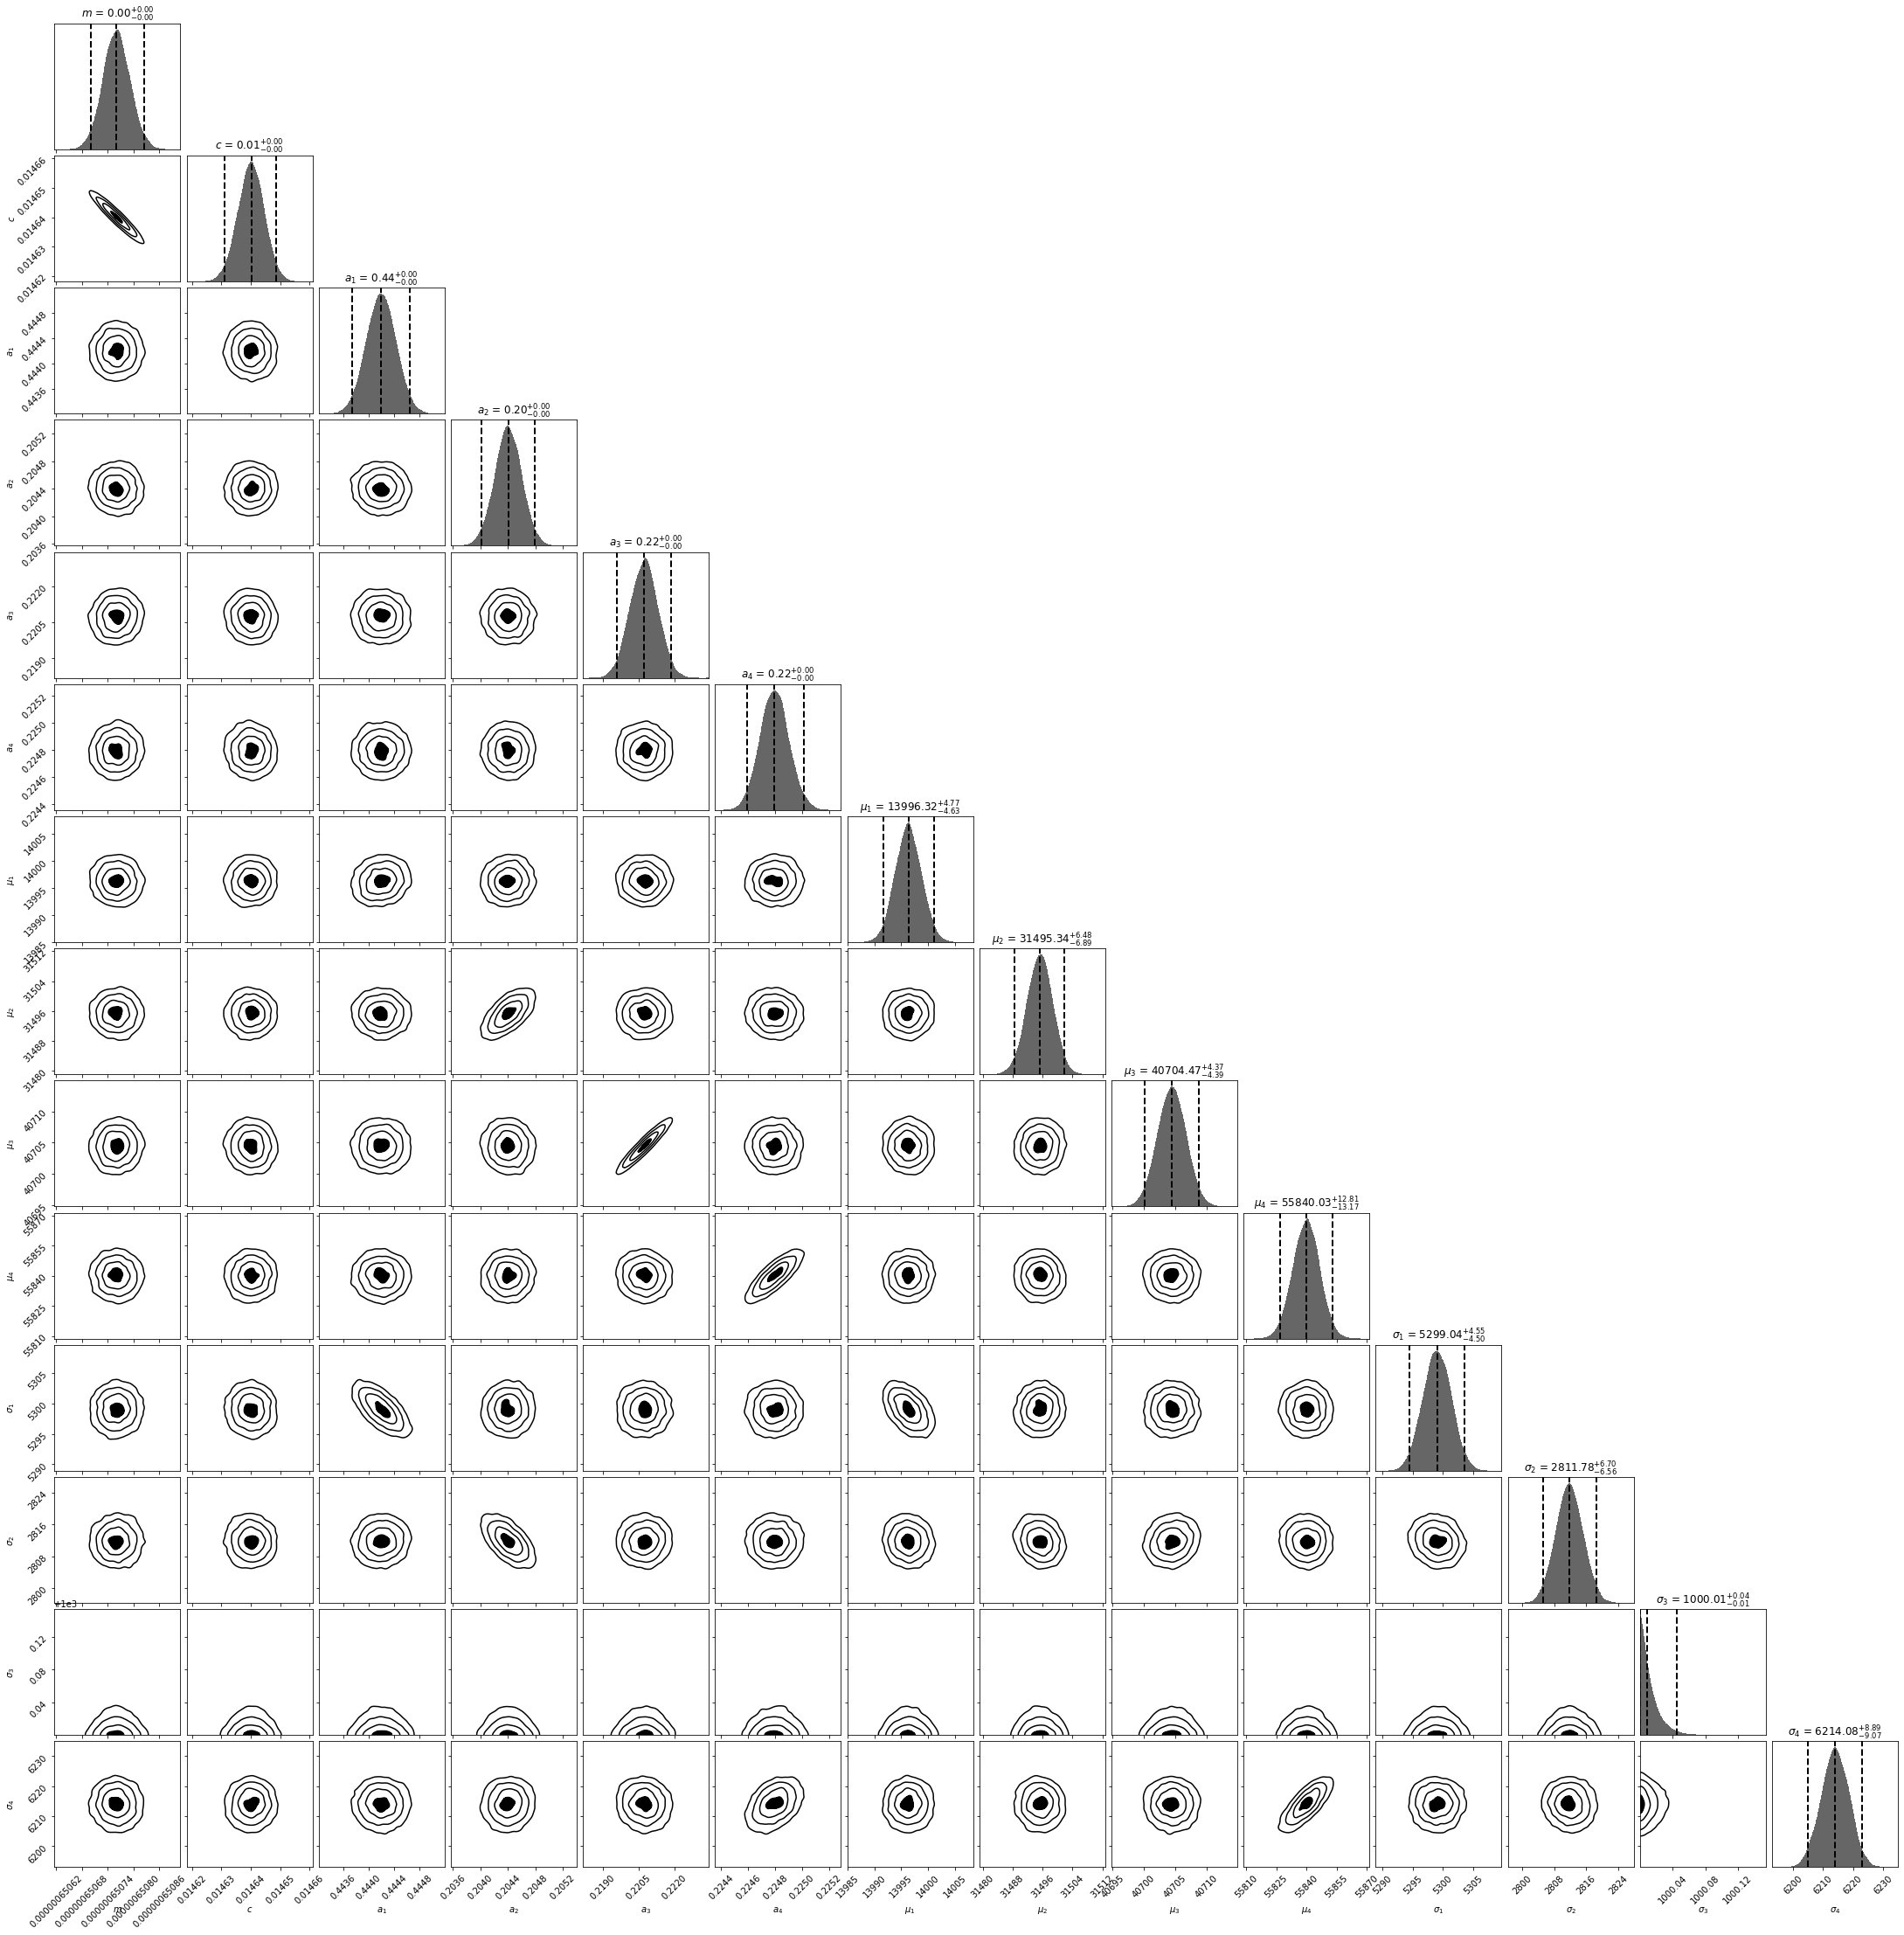

In [14]:
fig, axes = dyplot.cornerplot(dres, show_titles=True, labels=labels)

/Users/japa6985/opt/anaconda3/envs/dynesty12/lib/python3.9/site-packages/dynesty/plotting.py:315: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


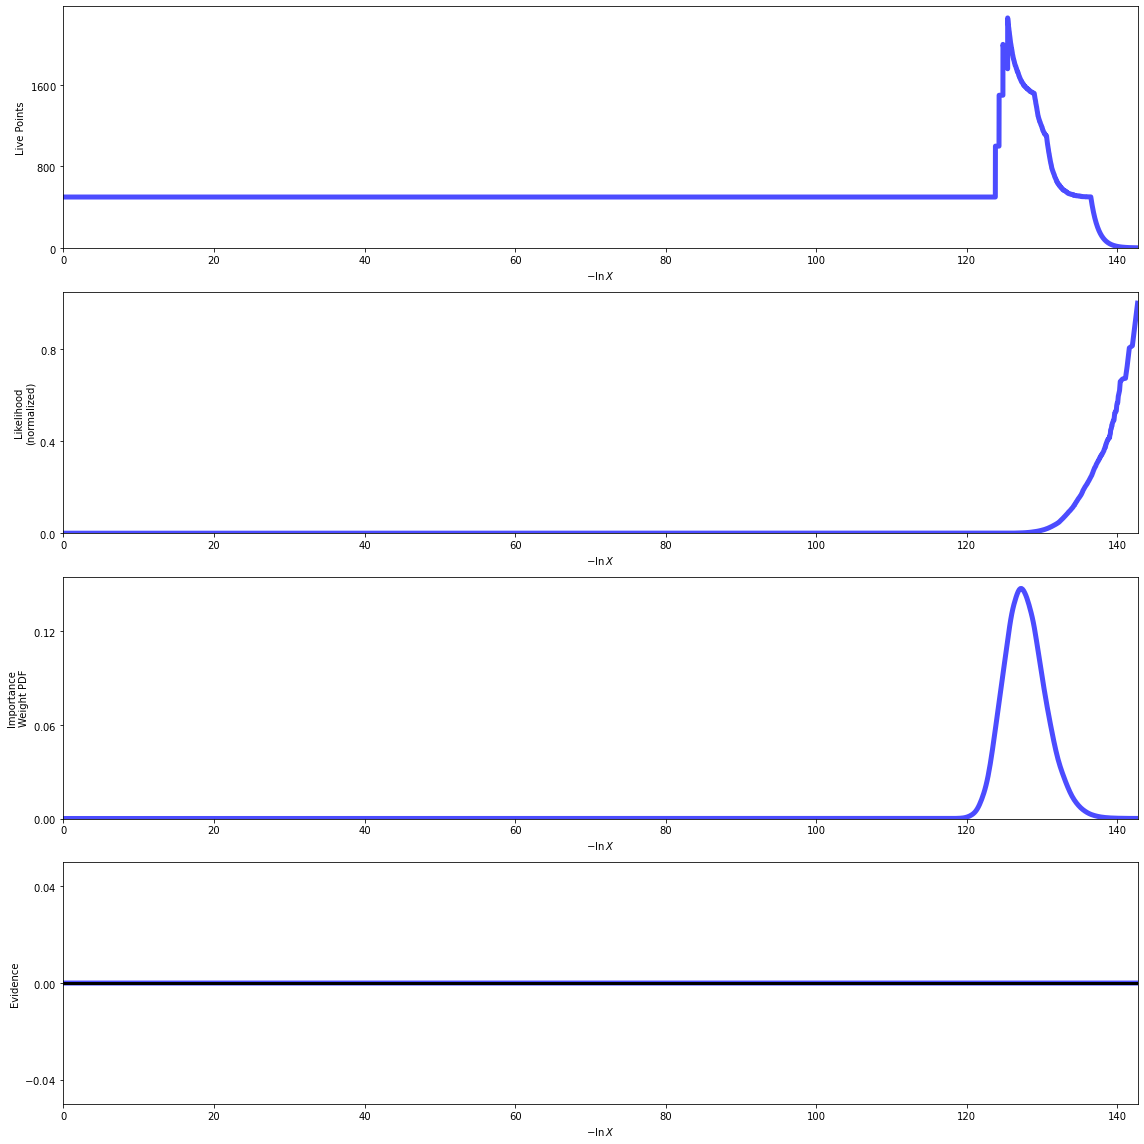

In [15]:
# analytic evidence solution
lnz_truth = 32000. * -np.log(2 * 10.)  # log(volume) of prior; log(like) is normalized
fig, axes = dyplot.runplot(dres, color='blue', lnz_truth=lnz_truth, truth_color='black')
fig.tight_layout()

In [16]:
weights = np.exp(dres['logwt'] - dres['logz'][-1])
posterior_samples = resample_equal(dres.samples, weights)

/Users/japa6985/opt/anaconda3/envs/dynesty12/lib/python3.9/site-packages/dynesty/utils.py:458: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


In [17]:
labels1 = ['m', 'c', 'a_1', 'a_2', 'a_3', 'a_4',\
    'mu_1', 'mu_2', 'mu_3', 'mu_4', 'sigma_1', 'sigma_2', 'sigma_3', 'sigma_4']

post_samps = {}
post_samps['samples'] = {}
for i in range(len(labels1)):
    post_samps['samples'][labels1[i]] = posterior_samples[:, i]

# logZ
post_samps['lnZ'] = dres.logz
post_samps['lnZ_err'] = dres.logzerr

# Data
post_samps['Data'] = {}
post_samps['Data']['velocity_m/s'] = velo_avg
post_samps['Data']['temp_k'] = temp_avg
post_samps['Data']['temp_err'] = temp_err

# Dumping a pickle
pickle.dump(post_samps,open('Onsala1.pkl','wb'))